## The Escape Velocity as a Cosmological Probe: Theory

In 2012, [Nandra et al. 2012](https://ui.adsabs.harvard.edu/abs/2012MNRAS.422.2945N/abstract) published research on the effect of an accelerating universe on a massive object. We start here.

Later that year, [Berhoozi et al. 2012](https://ui.adsabs.harvard.edu/abs/2013JCAP...06..019B/abstract) presented an expression for the radial and tangential escape speed from a cluster in this same context. Specifically, they provide the expression for a point source. Berhoozi introduced the term "equivalence radius" to define the point in space (relative to the center of a cluster) where the inward force of gravity (by the enclosed mass) balances the outward force created by the accelerated expansion of space-time:

$$r_{eq} = \sqrt[3]{\frac{GM}{-qH^2}} $$

where $H$ defines the expansion rate of the universe's scale factor: $\frac{\dot{a}}{a}$ and $q$ is the decelaration parameter, $q = -\frac{\ddot{a}{a}}{\dot{a}^2 } $. Note that the term $qH^2$ is then:

$$qH^2 = \frac{\ddot{a}}{a} = -\frac{4\pi G}{3} \sum_i \rho_i(1+3w_i)$$

where $w_i = p_i/(\rho_ic^2)$ and $p_i$, $\rho_i$ define the pressure and densities of the mass-energy components in the Friedmann equation. $w_i$ are the equations of state (0 for non-relativistic matter, 1/3 for radiation, and −1 for dark energy).

In 2016, our team began to take this theory into the obervational world. In [Miller et al. 2016](https://iopscience.iop.org/article/10.3847/0004-637X/822/1/41) we established escape velocity in the context of typical Poisson pairs. The Poisson equation relates the density to the potential via: 

$$\nabla^2{\Psi(r)} = 4\pi G \rho(r)$$,

where $\Psi$ defines the total effective potential which includes both the gravitational component as well as the pther piece from the acceleration of space-time. In the weak field (i.e. Newtonian) limit, $v^2_{escape}(r) = -2\Psi(r)$:

$$v_{esc} = \sqrt{(-2\Phi(r) + 2\Phi(r_{eq}) - qH^2(r^2 - r_{eq}^2)}$$
where $\Phi$ is the gravitational-only part of the potential. The other terms incorporate the effect of an accelerating space-time through $qH^2$.

It is $v_{escape}$ which can be measured using data or simulations in order to infer the total potential $\Psi$. A key result from Miller et al. 2016 is that the escape velocity at $r_{eq}$ is zero by definition. This established the baseline of the observable escape velocity (in 3D) using the Millennium simulation data. The accuracy and precision of the observable to the theory is percent level.


Later that year, [Stark et al. 2016](https://iopscience.iop.org/article/10.3847/0004-637X/830/2/109) established this technique as a true cosmological probe and the first results were reported on real data which direct comparisons (i.e., blind equivalent tests) to simulations.

In 2017, [Stark et al. 2017](https://ui.adsabs.harvard.edu/abs/2017PhRvD..96b3543S/abstract) built a Fisher Matrix formulism to make predictions on how well the escape velocity technique could constrain cosmological parameters.

### First, we import the needed libraries

In [1]:
import numpy as np
import path as Path
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image
from astropy.cosmology import FlatwCDM
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import LambdaCDM
from astropy.cosmology import wCDM
from astropy.cosmology import Flatw0waCDM
import scipy
from escape_functions_noastropy import *
from multiprocessing import Process
from multiprocessing import Queue
from multiprocessing import Pool
import emcee
import corner
from scipy.interpolate import interp1d
from scipy.stats import linregress

### We will be using Astropy's cosmology library as our base to define the models. 

Note that we will NOT use astropy cosmolgy objects in the MCMC analysis.

In [2]:
cosmo = FlatwCDM(H0=70, Om0=0.2,w0=-1)
cosmo = wCDM(H0=70, Om0=0.2,Ode0 = 0.8,w0=-1)
cosmo = FlatLambdaCDM(H0=70,Om0=0.2)
cosmo = LambdaCDM(H0=70, Om0=0.2, Ode0 = 0)
cosmo = Flatw0waCDM(H0=70, Om0=0.2, w0=-0.9, wa=0.2)

Below are the cosmologies we can use. This function takes the name of the cosmology object that we have defined and then figures out how to return a new vector of the pertinent cosmological parameters. We will later feed this vector to the MCMC analysis (as opposed to a full astropy cosmology object).

In [3]:
def cosmology(cosmology):
    case = cosmology.name
    if case == 'Flatw0waCDM':
        return [cosmology.Om0, cosmology.w0, cosmology.wa, cosmology.h]
    
    elif case == 'FlatwCDM':
        return [cosmology.Om0, cosmology.w0, cosmology.h]

    elif case == 'wCDM':
        return [cosmology.Om0, cosmology.Ode0, cosmology.w0,cosmology.h]
        
    elif case == 'LambdaCDM':
        return [cosmology.Om0, cosmology.Ode0, cosmology.h]

    elif case == 'FlatLambdaCDM':
        return [cosmology.Om0, cosmology.h]

Fun with numbers.

If you know some cosmology and have read the above theory preamble and/or references, none of the lines below should look foreign to you. If one does, please follow-up in the references.

In [4]:
cosmo = FlatLambdaCDM(H0=70,Om0=0.2,name='FlatLambdaCDM')
cosmo_params = cosmology(cosmo)
z=0.2
M200 = 1e15*u.solMass
rho_crit = cosmo.critical_density(z)
rho_crit = rho_crit.to(u.solMass / u.Mpc**3)
print 'Astropys critical density: ', rho_crit
print 'Internal critical density: ',rho_crit_z(z,cosmo_params,'FlatLambdaCDM')
R200crit =  (3*M200/(4*np.pi*200.* rho_crit))**(1./3.)
radius_array = np.linspace(0.3,2.0,100).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
theta_array = radius_array /cosmo.angular_diameter_distance(z)
R200crit =  (3*M200/(4*np.pi*200.* rho_crit))**(1./3.)
print 'Spherical R200 for a given M200: ', R200crit
G_newton = astroc.G.to( u.Mpc *  u.km**2 / u.s**2 / u.solMass).value #Mpc km2/s^2 kg
print 'Gravity (Mpc km2/s^2 kg), mass, cosmology: ', G_newton, M200, cosmo_params, cosmo.name
print 'q = ', q_z_function(z, cosmo_params,cosmo.name)
print 'r_eq = ', r_eq(0.2,M200,cosmo_params, cosmo.name)

Astropys critical density:  1.55793520483e+11 solMass / Mpc3
Internal critical density:  1.55793520483e+11 solMass / Mpc3
Spherical R200 for a given M200:  1.97141172229 Mpc
Gravity (Mpc km2/s^2 kg), mass, cosmology:  4.30091727007e-09 1e+15 solMass [0.2, 0.7] FlatLambdaCDM
q =  -0.547486033519553
r_eq =  11.1854377804 Mpc


Next, we define an escape velocity profile in a Flat $\Lambda$CDM Universe. We start with a chosen $M_{200}$. We call a cosmology object. We set the cosmologic parameters. We define a set of radial bins in physical coordinates (i.e., Mpc). We choose a redshift. We then convert those physical coordinates to angles on the sky.

We then call the function einasto_nfwM200_errors from the library. This function use a mass concentration relation and spherical symmetry to determine the einasto parameters which also fit this same escape velocity profile. If there is error (the second parameter), than a $\chi^2$ analysis is performed and errors on those parameters are returned.

The following block of code creates a single cluster with a specified M200, redshift, and its Einasto parameters for a flat LCDM cosmology with $\Omega_m = 0.2$ and $\Omega_{DE} = 0.8$. Given a fixed (to the local frame) physical set of radial bins, we then calculate the escape velocity profile given the observed radial profile on the sky. We use an NFW and and EINasto profile.

In [5]:
cosmo_name = 'LambdaCDM'
cosmo = LambdaCDM(H0=70, Om0=0.2,Ode0 = 0.8, name = cosmo_name)
cosmo_params = cosmology(cosmo)
z = np.array((0.2))
z = np.repeat(z,(1))
num_clus = len(z)
M200_orig = np.repeat(1e15*u.solMass,len(z))
M200_use = np.repeat(1e15,len(z))
N = np.repeat(100,len(z))
rho_0, h, n, = [],[],[]
for i in range(len(z)):
    M200,R200,conc,a,b,c, simga_a, sigma_b, sigma_c =  einasto_nfwM200_errors(M200, 0.001, z,cosmo_params, cosmo_name)
    rho_0 = np.append(rho_0,a)
    h = np.append(h, b)
    n = np.append(n,c)
rho_0 = np.resize(rho_0,(1,len(z)))
h = np.resize(h,(1,len(z)))
n = np.resize(n, (1,len(z)))
print 'Einasto rho_0, h, and n parameters: ',rho_0, h,n
rho_0_flatLCDM = rho_0
h_Om02Ode08_LCDM = h
n_Om02Ode08_LCDM = n
radial_bins = 10
radius_array = np.linspace(0.1,2.5,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
xdata = np.zeros((len(z),radial_bins))
for i in range(len(z)):
    xdata[i,:] = radius_array /D_A(z[i], cosmo_params, cosmo.name).value
r_Om02Ode08_EIN,vesc_Om02Ode08_EIN = v_esc_einasto(xdata,z,rho_0,h,n,N,cosmo_params, cosmo_name,num_clus)
r_Om02Ode08_NFW,vesc_Om02Ode08_NFW = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo_name, num_clus)

Einasto rho_0, h, and n parameters:  [[4.95983676e+17]] [[0.00015284]] [[3.93512083]]


escape_functions_noastropy.py:737: RuntimeWarning: invalid value encountered in power
  return rho_0*np.exp(-(r/h)**(1./n))


In [6]:
cosmo_name = 'FlatLambdaCDM'
cosmo = FlatLambdaCDM(H0=70, Om0=0.2,name = cosmo_name)
cosmo_params = cosmology(cosmo)
z = np.array((0.2))
z = np.repeat(z,(1))
num_clus = len(z)
M200_orig = np.repeat(1e15*u.solMass,len(z))
M200_use = np.repeat(1e15,len(z))
N = np.repeat(100,len(z))
radial_bins = 10
radius_array = np.linspace(0.1,2.5,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
xdata = np.zeros((len(z),radial_bins))
for i in range(len(z)):
    xdata[i] = radius_array /D_A(z[i], cosmo_params, cosmo.name).value

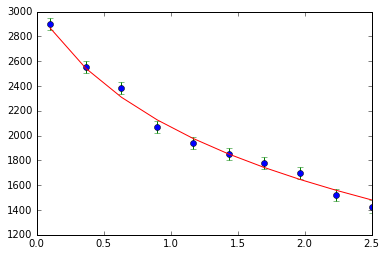

In [7]:
r,ydata = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo.name,num_clus)
error_kms = 50
ydata = ydata  + np.random.normal(0,error_kms,size=np.shape(ydata)) 
ydata_err = np.zeros(np.shape(ydata)) + error_kms

for i in range(len(z)):
    plt.plot(r[i],ydata[i],'o', label = 'Data '+ str(i))
    plt.errorbar(r[i],ydata[i],yerr=ydata_err[i], linestyle='None')
r,truth = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo.name,num_clus)
for i in range(len(z)):
    plt.plot(r[i],truth[i],'-', label = 'Truth '+ str(i))

In [8]:
def lnprior(theta):
    p_Omega_M = theta[0]
    p_little_h = theta[1]
    if not(0.05 < p_Omega_M < 0.5 and 0.5 < p_little_h < 1.0):
          return -np.inf
    return 0.0

In [9]:
def lnlike(theta, x, y, yerr): 
    p_theta_array = x
    p_z = z
    p_M200 = M200_use
    p_Omega_M = np.repeat(theta[0],(1))
    p_little_h = np.repeat(theta[1],(1))
    p_N = N
    p_num_clus = num_clus
    p_cosmo_name = cosmo_name
    p_cosmo_params = [p_Omega_M,p_little_h]
    ymodel_fixed = lambda p_theta_array,p_cosmo_params,p_cosmo_name:v_esc_NFW_M200(p_theta_array,p_z,p_M200,p_N,p_cosmo_params,p_cosmo_name,p_num_clus)
    r_cosmo, ymodel = ymodel_fixed(p_theta_array,p_cosmo_params,p_cosmo_name)
#    print model
    inv_sigma2 = 1.0/(yerr**2)
#    print -0.5*(np.sum((y-ymodel)**2*inv_sigma2))
    return np.nan_to_num(-0.5*(np.sum((y-ymodel)**2*inv_sigma2)))

In [10]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    ll = lnlike(theta, x, y, yerr)
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(ll):
        return -np.inf    
    return lp + lnlike(theta, x, y, yerr)

In [11]:
ndim, nwalkers, nsteps = 2, 100, 1000
start_pos = [cosmo.Om0, cosmo.h]
p0 = np.transpose([np.random.uniform(0.05,0.5,size=nwalkers), np.random.uniform(0.5,0.95,size=nwalkers)])

In [12]:
pool = Pool(processes=35)     
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xdata, ydata, ydata_err),pool=pool)
sampler.run_mcmc(p0, nsteps)

State([[0.19140186 0.7085203 ]
 [0.20335595 0.71892926]
 [0.18038988 0.73149635]
 [0.16898171 0.70195462]
 [0.18592774 0.71302924]
 [0.32288375 0.64410818]
 [0.13051868 0.74423243]
 [0.44859205 0.57507835]
 [0.13155215 0.75143131]
 [0.09808278 0.72882045]
 [0.32153928 0.62933788]
 [0.13615572 0.73499674]
 [0.30193372 0.65729175]
 [0.11850534 0.73849429]
 [0.05957849 0.75873519]
 [0.26260103 0.66525174]
 [0.4582355  0.57451794]
 [0.16253968 0.69557009]
 [0.05166727 0.81271478]
 [0.24903185 0.68702949]
 [0.10624332 0.73406664]
 [0.12721641 0.72049695]
 [0.16853997 0.72851581]
 [0.12804553 0.73707152]
 [0.16113115 0.70796135]
 [0.05463588 0.78485707]
 [0.10675747 0.74949133]
 [0.40920862 0.62224286]
 [0.27561072 0.67541421]
 [0.16640365 0.68264663]
 [0.15706379 0.71991085]
 [0.08327449 0.77179383]
 [0.17499856 0.70929395]
 [0.25755036 0.66776852]
 [0.35736057 0.62347016]
 [0.07514364 0.76205625]
 [0.10677842 0.73317546]
 [0.25245085 0.66493454]
 [0.19177237 0.70246853]
 [0.14520137 0.7490

(100, 1000, 2)


/u/home/christoq/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:6447: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/u/home/christoq/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:6447: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


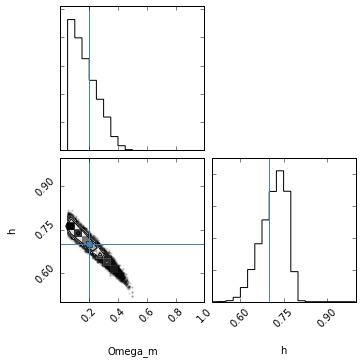

67
median(Omega_M) =  0.1591805481323 +/- 0.09924270466875187 0.07683984226580731
median(h) =  0.7207544157853655 +/- 0.037989629086139676 0.05285850821389748
Truth:  0.2 0.7


In [13]:
burn = 100
samples = sampler.chain[:, burn:, :].reshape((-1, 2))
print np.shape(sampler.chain)
#truths = [rho_s, r_s, M200.value],
#fig = corner.corner(samples[:,:], labels=["Omega_m", "h","M200", "z"], range=[(0,1), (0.5,1.0), (1e14,2e15), (0.09,1.1)])
fig = corner.corner(samples[:,:], labels=["Omega_m", "h"], truths = [cosmo.Om0, cosmo.h], range=[(0,1), (0.5,1.0)])
plt.show()
percentile_array = np.arange(33-16.5,67+16.5, 1.0)
print len(percentile_array)
Omega_M_fit =  np.percentile(sampler.chain[:,:,0],percentile_array)
h_fit =  np.percentile(sampler.chain[:,:,1],percentile_array)
Omega_M_fit_50 =  np.percentile(sampler.chain[:,:,0],50)
h_fit_50 = np.percentile(sampler.chain[:,:,1],50)
Omega_M_fit_33 =  np.percentile(sampler.chain[:,:,0],33-16.5)
h_fit_33 = np.percentile(sampler.chain[:,:,1],33-16.5)
Omega_M_fit_67 =  np.percentile(sampler.chain[:,:,0],67+13.5)
h_fit_67 = np.percentile(sampler.chain[:,:,1],67+16.5)
print 'median(Omega_M) = ', Omega_M_fit_50, '+/-', Omega_M_fit_67-Omega_M_fit_50, Omega_M_fit_50-Omega_M_fit_33
print 'median(h) = ', h_fit_50, '+/-', h_fit_67-h_fit_50, h_fit_50-h_fit_33
print 'Truth: ', cosmo.Om0, cosmo.h\

In [14]:
burn = 200
Omega_m_fitted = sampler.chain[:,burn:,0].flatten()
h_fitted = sampler.chain[:,burn:,1].flatten()
rand_vec = np.random.uniform(1,len(Omega_m_fitted),size=5000).astype(int)
slope, intercept, r_value, p_value, std_err = linregress(Omega_m_fitted,h_fitted)
print slope, intercept
print std_err

-0.4764377600006436 0.7974898792087898
0.0005213028960007099


[100]


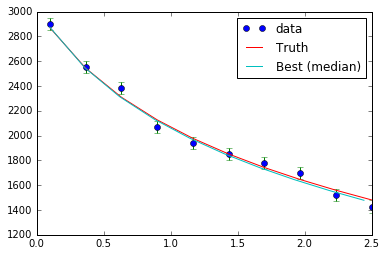

In [15]:
print N
plt.plot(radius_array,ydata[0], 'o', linestyle='None',label = 'data')
plt.errorbar(radius_array,ydata[0],yerr=ydata_err[0], linestyle='None')
r_truth,truth = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo.name,num_clus)
plt.plot(r_truth[0], truth[0], '-', label = 'Truth')
r_fit,fit = v_esc_NFW_M200(xdata,z,M200_use,N,[Omega_M_fit_50,h_fit_50,], cosmo.name,num_clus)
plt.plot(r_fit[0], fit[0], '-', label = 'Best (median)')
plt.legend()

In [16]:
cosmo_name = 'FlatLambdaCDM'
cosmo = FlatLambdaCDM(H0=70, Om0=0.2,name = cosmo_name)
cosmo_params = cosmology(cosmo)
z = np.array((0.2))
z = np.repeat(z,(1))
num_clus = len(z)
M200_orig = np.repeat(1e15*u.solMass,len(z))
M200_use = np.repeat(1e15,len(z))
N = np.repeat(100,len(z))
radial_bins = 10
radius_array = np.linspace(0.1,2.5,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
xdata = np.zeros((len(z),radial_bins))
for i in range(len(z)):
    xdata[i] = radius_array /D_A(z[i], cosmo_params, cosmo.name).value

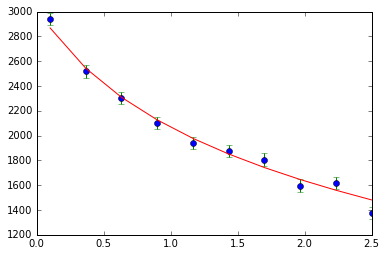

In [17]:
r,ydata = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo.name,num_clus)
error_kms = 50
ydata = ydata  + np.random.normal(0,error_kms,size=np.shape(ydata)) 
ydata_err = np.zeros(np.shape(ydata)) + error_kms

for i in range(len(z)):
    plt.plot(r[i],ydata[i],'o', label = 'Data '+ str(i))
    plt.errorbar(r[i],ydata[i],yerr=ydata_err[i], linestyle='None')
r,truth = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo.name,num_clus)
for i in range(len(z)):
    plt.plot(r[i],truth[i],'-', label = 'Truth '+ str(i))

In [18]:
def lnprior(theta):
    p_qH2 = theta[0]
    if not(-10000 < p_qH2 < 0):
          return -np.inf
    return 0.0

In [19]:
def lnlike(theta, x, y, yerr): 
    p_theta_array = x
    p_z = z
    p_M200 = M200_use
    p_qH2 = theta[0]
    p_cosmo_params = cosmo_params
    p_cosmo_name = cosmo_name
    p_N = N
    p_num_clus = num_clus
    ymodel_fixed = lambda p_theta_array,p_qH2:v_esc_NFW_M200_qH2(p_theta_array,p_z,p_M200,p_N,p_qH2,p_cosmo_params,p_cosmo_name,p_num_clus)
    r_cosmo, ymodel = ymodel_fixed(p_theta_array,p_qH2)
#    print model
    inv_sigma2 = 1.0/(yerr**2)
#    print -0.5*(np.sum((y-ymodel)**2*inv_sigma2))
    return np.nan_to_num(-0.5*(np.sum((y-ymodel)**2*inv_sigma2)))

In [20]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    ll = lnlike(theta, x, y, yerr)
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(ll):
        return -np.inf    
    return lp + lnlike(theta, x, y, yerr)

In [21]:
ndim, nwalkers, nsteps = 1, 1000, 500
p0 = np.transpose([np.random.uniform(-10000,0,size=nwalkers)])

In [22]:
pool = Pool(processes=35)     
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xdata, ydata, ydata_err),pool=pool)
sampler.run_mcmc(p0, nsteps)

State([[-4484.05434864]
 [-3771.31417827]
 [-3461.14758848]
 [-3554.96639303]
 [-3279.44621175]
 [-3543.6689347 ]
 [-3375.56386225]
 [-3097.25057827]
 [-3445.02159181]
 [-3080.00600149]
 [-4471.15907629]
 [-3705.67281579]
 [-3339.31653818]
 [-3066.04240668]
 [-4616.07155938]
 [-4602.33376355]
 [-3410.02244807]
 [-2871.6984204 ]
 [-3113.15701958]
 [-3152.23186151]
 [-3199.53066851]
 [-2880.48170412]
 [-3567.86720947]
 [-3607.50914853]
 [-3088.35910767]
 [-3158.87541409]
 [-3554.7258027 ]
 [-4155.7301218 ]
 [-3438.92237769]
 [-3177.68182376]
 [-3139.05237624]
 [-2858.50943136]
 [-3192.84920226]
 [-3799.78445041]
 [-3118.18829895]
 [-3286.48656444]
 [-3217.33756551]
 [-3867.44306014]
 [-2741.40954243]
 [-3552.736944  ]
 [-3496.87728683]
 [-3236.03141228]
 [-3627.67891393]
 [-2615.1953044 ]
 [-3819.68782844]
 [-3659.49434299]
 [-3514.09246567]
 [-3011.36333782]
 [-3495.13189091]
 [-3102.15634628]
 [-3397.31634667]
 [-3131.63055895]
 [-2639.2215089 ]
 [-2765.0577102 ]
 [-3095.4392061 ]
 [-2

[-3073.28]
(1000, 500, 1) (400000, 1)


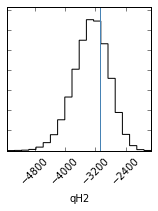

67
median(qH2) =  -3292.7600412026504 +/- 427.2931585206138 471.76758107816477
truth =  [-3073.28]


In [23]:
burn = 100
H_z = H_z_function(z,cosmo_params,cosmo.name).value
q_z= q_z_function(z,cosmo_params,cosmo.name)
print H_z**2.0*q_z
samples = sampler.chain[:, burn:,0:].reshape((-1, 1))
print np.shape(sampler.chain), np.shape(samples)
fig = corner.corner(samples, labels=["qH2"], truths= [(H_z**2.0*q_z)])
plt.show()
percentile_array = np.arange(33-16.5,67+16.5, 1.0)
print len(percentile_array)
qH2_fit =  np.percentile(sampler.chain[:,burn:,0],percentile_array)
qH2_fit_50 =  np.percentile(sampler.chain[:,burn:,0],50)
qH2_fit_33 =  np.percentile(sampler.chain[:,burn:,0],33-16.5)
qH2_fit_67 =  np.percentile(sampler.chain[:,burn:,0],67+16.5)
print 'median(qH2) = ', qH2_fit_50, '+/-', qH2_fit_67-qH2_fit_50, qH2_fit_50-qH2_fit_33
sigma_qH2_fit = (qH2_fit_67-qH2_fit_50 + qH2_fit_50-qH2_fit_33)/2.0
H_z = H_z_function(z,cosmo_params,cosmo.name).value
q_z= q_z_function(z,cosmo_params,cosmo.name)
print 'truth = ', H_z**2.0*q_z

median(qH2) =  -3069.45861178048 +/- 882.6157628030587 1199.7382618174252 Om=0.2
median(qH2) =  -2740.3968208140213 +/- 794.0167158673407 1123.8039894959147 Om = 0.1
median(qH2) =  -3392.601505853366 +/- 949.7394756548924 1276.6696775446298 Om = 0.3

[[0.1   0.367 0.633 0.9   1.167 1.433 1.7   1.967 2.233 2.5  ]]


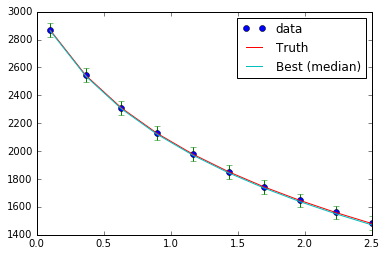

In [24]:
print r
r,ydata = v_esc_NFW_M200_qH2(xdata,z,M200_use,N,H_z**2.0*q_z,cosmo_params, cosmo.name,num_clus)
plt.plot(r[0],ydata[0], 'o', linestyle='None',label = 'data')
plt.errorbar(r[0],ydata[0],yerr=ydata_err[0], linestyle='None')
r,truth = v_esc_NFW_M200_qH2(xdata,z,M200_use,N,H_z**2.0*q_z,cosmo_params, cosmo.name,num_clus)
plt.plot(r[0], truth[0], '-', label = 'Truth')
r,truth = v_esc_NFW_M200_qH2(xdata,z,M200_use,N,qH2_fit_50, cosmo_params,cosmo.name,num_clus)
plt.plot(r[0], truth[0], '-', label = 'Best (median)')
plt.legend()

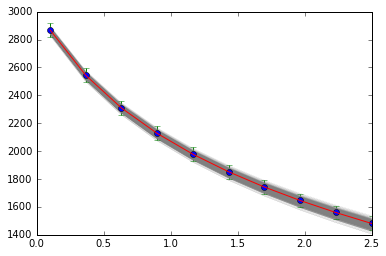

In [25]:
burn = 100
qH2_fitted = sampler.chain[:,burn:,0].flatten()
rand_vec = np.random.uniform(1,len(qH2_fitted),size=1000).astype(int)
for i in range(1000):
    r,fitted = v_esc_NFW_M200_qH2(xdata,z,M200_use,N,qH2_fitted[rand_vec[i]],[cosmo.Om0,cosmo.h],cosmo.name, num_clus)
    plt.plot(r[0], fitted[0],'grey',lw=0.1)
plt.plot(r[0],ydata[0], 'o', linestyle='None',label = 'data')
plt.errorbar(r[0],ydata[0],yerr=ydata_err[0], linestyle='None')
r,truth = v_esc_NFW_M200_qH2(xdata,z,M200_use,N,H_z**2.0*q_z,[cosmo.Om0,cosmo.h], cosmo.name, num_clus)
plt.plot(r[0], truth[0], '-', label = 'Truth')
plt.show()

In [26]:
print qH2_fit_50/(70.0**2.0),qH2_fit_33/(70.0**2.0), qH2_fit_67/(70.0**2.0), H_z**2.0*q_z/(H_z**2.0)

-0.671991845143398 -0.7682709433226154 -0.5847891597310279 [-0.54748603]


In [27]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.2,name = 'FlatLambdaCDM')
cosmo_params = cosmology(cosmo)
z = np.array((0.05))
z = np.repeat(z,(1))
num_clus = len(z)
M200_orig = np.repeat(5e14*u.solMass,len(z))
M200_use = np.repeat(5e14,len(z))
N = np.repeat(100,len(z))
radial_bins = 10
radius_array = np.linspace(0.1,2.0,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
xdata = np.zeros((len(z),radial_bins))
for i in range(len(z)):
    xdata[i] = radius_array /D_A(z[i], cosmo_params, cosmo.name).value

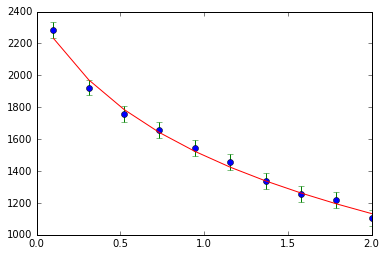

In [28]:
r,ydata = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo.name,num_clus)
error_kms = 50
ydata = ydata  + np.random.normal(0,error_kms,size=np.shape(ydata)) 
ydata_err = np.zeros(np.shape(ydata)) + error_kms
for i in range(len(z)):
    plt.plot(r[i],ydata[i],'o', label = 'Data '+ str(i))
    plt.errorbar(r[i],ydata[i],yerr=ydata_err[i], linestyle='None')
r,truth = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo.name,num_clus)
for i in range(len(z)):
    plt.plot(r[i],truth[i],'-', label = 'Truth '+ str(i))

In [29]:
cosmo_name = 'FlatLambdaCDM'
cosmo = FlatLambdaCDM(H0=70, Om0=0.2,name = cosmo_name)
cosmo_params = cosmology(cosmo)
z = np.arange(0.05,0.35,0.01)
num_clus = len(z)
print num_clus
M200_orig = np.repeat(1e15*u.solMass,len(z))
M200_use = np.repeat(1e15,len(z))
N = np.repeat(150,len(z))
radial_bins = 10
radius_array = np.linspace(0.1,2.0,radial_bins).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
xdata = np.zeros((len(z),radial_bins))
for i in range(len(z)):
    xdata[i] = radius_array /D_A(z[i], cosmo_params, cosmo.name).value

30


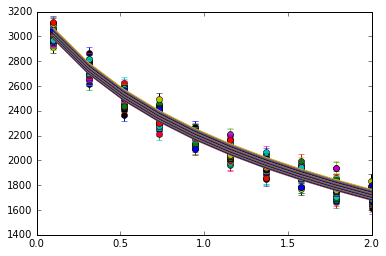

In [30]:
r,ydata = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo.name,num_clus)
error_kms = 50
ydata = ydata  + np.random.normal(0,error_kms,size=np.shape(ydata)) 
ydata_err = np.zeros(np.shape(ydata)) + error_kms

for i in range(len(z)):
    plt.plot(r[i],ydata[i],'o', label = 'Data '+ str(i))
    plt.errorbar(r[i],ydata[i],yerr=ydata_err[i], linestyle='None')
r,truth = v_esc_NFW_M200(xdata,z,M200_use,N,cosmo_params, cosmo.name,num_clus)
for i in range(len(z)):
    plt.plot(r[i],truth[i],'-', label = 'Truth '+ str(i))

In [31]:
def lnprior(theta):
    p_Omega_M = theta[0]
    p_little_h = theta[1]
    if not(0.05 < p_Omega_M < 0.5 and 0.5 < p_little_h < 1.0):
          return -np.inf
    return 0.0

In [32]:
def lnlike(theta, x, y, yerr): 
    p_theta_array = x
    p_z = z
    p_M200 = M200_use
    p_Omega_M = theta[0]
    p_little_h = theta[1]
    p_N = N
    p_num_clus = num_clus
    p_cosmo_name = cosmo_name
    p_cosmo_params = [p_Omega_M,p_little_h]
    ymodel_fixed = lambda p_theta_array,p_cosmo_params,p_cosmo_name:v_esc_NFW_M200(p_theta_array,p_z,p_M200,p_N,p_cosmo_params,p_cosmo_name,p_num_clus)
    r_cosmo, ymodel = ymodel_fixed(p_theta_array,p_cosmo_params,p_cosmo_name)
#    print model
    inv_sigma2 = 1.0/(yerr**2)
#    print -0.5*(np.sum((y-ymodel)**2*inv_sigma2))
    return np.nan_to_num(-0.5*(np.sum((y-ymodel)**2*inv_sigma2)))

In [33]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    ll = lnlike(theta, x, y, yerr)
    if not np.isfinite(lp):
        return -np.inf
    if not np.isfinite(ll):
        return -np.inf    
    return lp + lnlike(theta, x, y, yerr)

In [34]:
ndim, nwalkers, nsteps = 2, 100, 1000
start_pos = [cosmo.Om0, cosmo.h]
p0 = np.transpose([np.random.uniform(0.05,0.5,size=nwalkers), np.random.uniform(0.5,0.95,size=nwalkers)])

In [ ]:
pool = Pool(processes=35)     
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(xdata, ydata, ydata_err),pool=pool)
sampler.run_mcmc(p0, nsteps)

In [ ]:
burn = 400
samples = sampler.chain[:, burn:, :].reshape((-1, 2))
print np.shape(sampler.chain)
#truths = [rho_s, r_s, M200.value],
#fig = corner.corner(samples[:,:], labels=["Omega_m", "h","M200", "z"], range=[(0,1), (0.5,1.0), (1e14,2e15), (0.09,1.1)])
fig = corner.corner(samples[:,:], labels=["Omega_m", "h"], truths = [cosmo.Om0, cosmo.h], range=[(0,0.4), (0.6,0.8)])
plt.show()
percentile_array = np.arange(33-16.5,67+16.5, 1.0)
print len(percentile_array)
Omega_M_fit =  np.percentile(sampler.chain[:,burn:,0],percentile_array)
h_fit =  np.percentile(sampler.chain[:,burn:,1],percentile_array)
Omega_M_fit_50 =  np.percentile(sampler.chain[:,burn:,0],50)
h_fit_50 = np.percentile(sampler.chain[:,burn:,1],50)
Omega_M_fit_33 =  np.percentile(sampler.chain[:,burn:,0],33-16.5)
h_fit_33 = np.percentile(sampler.chain[:,burn:,1],33-16.5)
Omega_M_fit_67 =  np.percentile(sampler.chain[:,burn:,0],67+13.5)
h_fit_67 = np.percentile(sampler.chain[:,burn:,1],67+16.5)
print 'median(Omega_M) = ', Omega_M_fit_50, '+/-', Omega_M_fit_67-Omega_M_fit_50, Omega_M_fit_50-Omega_M_fit_33
print 'median(h) = ', h_fit_50, '+/-', h_fit_67-h_fit_50, h_fit_50-h_fit_33
print 'Truth: ', cosmo.Om0, cosmo.h

In [ ]:
median(Omega_M) =  0.16020498366050426 +/- 0.01405155129423255 0.01522627838347948
median(h) =  0.720601160633259 +/- 0.007356247709764618 0.007696122687491647
median(Omega_M) =  0.21746518705884668 +/- 0.013590641406457576 0.014819494484690166
median(h) =  0.6938228355105844 +/- 0.007340051381206525 0.007524068114170057
Truth:  0.2 0.7

In [ ]:
M200 = 1e15*u.solMass
cosmo = wCDM(H0=70, Om0=0.2,Ode0 = 0.8,w0=-1,name = 'wCDM')
cosmo_params = cosmology(cosmo)
radius_array = np.linspace(0.3,2.0,100).round(3) #specify radius array for profiles. used in v_esc(r) funcs below.
z = 0.2
theta_array = radius_array /D_A(z,cosmo_params, cosmo.name)
real_error = []
real_mean = []
corr_coef = 0.2
for i in range(16):
    M200,R200,conc, rho_0, h,n, sigma_rho_0, sigma_h,sigma_n =  einasto_nfwM200_errors(M200, np.float(i)/20.0, z,cosmo_params, cosmo.name)
    M200_einasto = 4*np.pi*integrate.quad(rho_einasto_int,0,R200.value,args=(rho_0,h,n))[0]
    M200_einasto_p = 4*np.pi*integrate.quad(rho_einasto_int,0,R200.value,args=(rho_0+sigma_rho_0, h+corr_coef*sigma_h, n+sigma_n ))[0]
    M200_einasto_m = 4*np.pi*integrate.quad(rho_einasto_int,0,R200.value,args=(rho_0-sigma_rho_0, h-corr_coef*sigma_h, n-sigma_n ))[0]
    real_error =  np.append(real_error,((1-M200_einasto_m) + (M200_einasto_p-1))/(2*M200_einasto))
    real_mean =  np.append(real_mean,M200_einasto)
plt.plot(np.arange(0,0.8,0.05),real_error,'o')
plt.plot([0,1],[0,1])
plt.xlabel('Input M$_{200}$ Error')
plt.ylabel('Einasto Fitted M$_{200}$ Error')
#Note the 0.7, which is given in Alejo's paper's appendix. We need it!
print 'Mean fit (1e15) = ', np.sum(real_mean)/16/1e15

M200,R200,conc,rho_0, h,n, sigma_rho_0, sigma_h,sigma_n =  einasto_nfwM200_errors(M200, 0.2, z,cosmo_params, cosmo.name)
print 'M200 = ', M200
print 'R200 (sphere) = ', R200
print 'Conc (Sereno) = ', conc
print 'n = ',n
print 'sigma n = ', sigma_n
print 'rho_0 = ',rho_0
print 'sigma_rho_0 = ', sigma_rho_0
print 'h = ', h
print 'sigma_h = ', corr_coef*h

In [ ]:
M200 = 5e14*u.solMass
cosmo = wCDM(H0=70, Om0=0.2,Ode0 = 0.8,w0=-1,name = 'wCDM')
cosmo_params = cosmology(cosmo)
radius_array = np.linspace(0.3,2.0,100).round(3)* u.Mpc #specify radius array for profiles. used in v_esc(r) funcs below.
z = 0.2
theta_array = radius_array /D_A(z,cosmo_params, cosmo.name)
real_error = []
real_mean = []
corr_coef = 0.85
for i in range(16):
    M200,R200,conc,rho_s, sigma_rho_s,r_s, sigma_r_s =  nfws_errors(M200, np.float(i)/20.0, z,cosmo_params, cosmo.name)
    M200_nfws = 4*np.pi*integrate.quad(rhos_nfw_int,0,R200.value,args=(rho_s, r_s))[0]
    M200_nfws_p = 4*np.pi*integrate.quad(rhos_nfw_int,0,R200.value,args=(rho_s+sigma_rho_s,r_s+corr_coef*sigma_r_s))[0]
    M200_nfws_m = 4*np.pi*integrate.quad(rhos_nfw_int,0,R200.value,args=(rho_s-sigma_rho_s,r_s-corr_coef*sigma_r_s))[0]
    real_error =  np.append(real_error,((1-M200_nfws_m) + (M200_nfws_p-1))/(2*M200_nfws))
    real_mean =  np.append(real_mean,M200_nfws)
plt.plot(np.arange(0,0.8,0.05),real_error,'o')
plt.plot([0,1],[0,1])
plt.xlabel('Input M$_{200}$ Error')
plt.ylabel('NFW Fitted M$_{200}$ Error')
#Note the 0.7, which is given in Alejo's paper's appendix. We need it!
print 'Mean fit (1e15) = ', np.sum(real_mean)/16/1e15
M200,R200,conc,rho_s, sigma_rho_s,r_s, sigma_r_s =  nfws_errors(M200, 0.2, z,cosmo_params, cosmo.name)

print 'M200 = ', M200/1e14
print 'R200 (sphere) = ', R200
print 'Conc (Sereno) = ', conc
print 'rho_s/1e14 = ' , rho_s/1e14
print 'sigma rho_s/1e14 = ' , sigma_rho_s/1e14
print 'r_s = ',r_s
print 'sigma r_s = ', sigma_r_s